In [1]:
%matplotlib inline

"""
Import all the necessary packages
"""
import tensorflow as tf
import numpy as np
import functools
import random
import argparse
from multiprocessing import Pool, Process, cpu_count
import random
import pickle as pkl
import os
import codecs
from pprint import pprint
import sys
import re
from gensim.models import Word2Vec
from IPython import display
import pandas as pd 
import seaborn as sn
import matplotlib.pyplot as plt
import codecs 
from collections import OrderedDict, Counter


/home/vilstrup/anaconda2/lib/python2.7/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


In [2]:
def analyse_training_file(training_file):
    """
    Analyse the amount of features in the training dataset. The data should
    look like the following:

    Mikkel feat1 feat2 ... B-PERS
    Vilstrup feat1 feat2 ... I-PERS
    is feat1 feat2 ... O
    the feat1 feat2 ... O
    author feat1 feat2 ... O
    ...

    where feat1 feat2 ... are features related to the word on the left
    It is assumed that the features never change position, and that each feature
    is seperated by a space (" ").
    """
    lines = codecs.open(training_file, encoding="utf-8").readlines()
    lines = [l for l in lines if "-DOCSTART-" not in l]

    num_features = 0
    for line in lines:
        num_features = max(num_features, len(line.split()) - 1) # find the maximum amount of features

    features = [{} for i in range(num_features)] # create a dictionary for each feature

    max_length = 0
    current_length = 0
    # Iterate through all the lines to get the categories of each feature
    for line in lines:
        if line in ['\n', '\r\n']:
            # this is the end of a sentence.
            max_length = min(MAX_SENTENCE_LENGTH, max(max_length, current_length))
            current_length = 0
            continue
        else:
            current_length +=1
            words = line.split()[1:] # discard the word on the left

            for index, word in enumerate(words):
                #if not re.match("[A-Z]+", word):
                #    continue
                if word not in features[index]:
                    features[index][word] = True

    max_categories = 0
    for keys in [f.keys() for f in features]:
        max_categories = max(max_categories, len(keys))

    features = [f.keys() for f in features]
    
    word_dim = WORD_DIM + 4  # We add the capital features initially
    for feature in features[:-1]:
        word_dim += len(feature)
    
    targets = len(features[-1])
    
    return num_features, max_categories, max_length, word_dim, targets, features

In [6]:
"""
Define All data parameters
"""

WORD_DIM = 300
MAX_SENTENCE_LENGTH = 30

TARGET_LANGUAGE="ned" # The language one wishes to train for
DATA_DIR="data" # path to coNLL data set


TRAINING_FILE="{}/{}.train".format(DATA_DIR, TARGET_LANGUAGE)
DEV_FILE="{}/{}.testa".format(DATA_DIR, TARGET_LANGUAGE)
VALIDATION_FILE="{}/{}.testb".format(DATA_DIR, TARGET_LANGUAGE)

EMBEDDING_DIR="embeddings" # path to the location of the word embeddings
EMBEDDING_FILE="{}/{}.bin".format(EMBEDDING_DIR, TARGET_LANGUAGE)

FEATURE_AMOUNT, \
MAX_FEATURE_CATEGORIES, \
MAX_SENTENCE_LENGTH, \
EMBEDDING_LENGTH, \
NUM_TARGETS, \
FEATURES = analyse_training_file(TRAINING_FILE)

NUM_TARGETS = 5

"""
Sort the targets to ensure that the predictions vs. the targets is in order and can be reasoned about
"""
for feature in FEATURES:
    feature.sort(reverse=True)

print("""
Word Dimension: {word_dim}            The size of the original word embeddings
MAX_SENTENCE_LENGTH: {sent_len}        The maximum length a sentence is allowed to have
FEATURE_AMOUNT: {feat_am}              The amount of imput features including the word itself
MAX_FEATURE_CATEGORIES: {max_feat_cat}     The size of the max amount of categories within one feature (words not included)
INPUT EMBEDDING LENGTH: {emb_len}    The final size of the embedding (one-hot feature embbedings + word embedding)
NUM_TARGETS: {num_tar}                 The number of possible targets that the model should predict
""".format(word_dim=WORD_DIM, 
           sent_len=MAX_SENTENCE_LENGTH, 
           feat_am=FEATURE_AMOUNT, 
           max_feat_cat=MAX_FEATURE_CATEGORIES,
           emb_len=EMBEDDING_LENGTH,
           num_tar=NUM_TARGETS))

print("\nAvailable Extra Word Features")
for feature in FEATURES[:-1]:
    print("{}\n".format(feature))


print("\nAvailable Targets")
print(FEATURES[-1], "\n")

"""
Create a dictionary to be able to convert the onehot vectors back to their original label
"""
TARGET_LOCATION = {
     u'LOC': 4,
     u'MISC': 3,
     u'ORG': 2,
     u'PER': 1,
     u'O': 0
}

LOCATION_TARGETS = {
    0: u'O',
    1: u'PER',
    2: u'ORG',
    3: u'MISC',
    4: u'LOC',
 }


print("Location -> Target")
pprint(TARGET_LOCATION)

print ""

print("Target -> Location")
pprint(LOCATION_TARGETS)


Word Dimension: 300            The size of the original word embeddings
MAX_SENTENCE_LENGTH: 30        The maximum length a sentence is allowed to have
FEATURE_AMOUNT: 2              The amount of imput features including the word itself
MAX_FEATURE_CATEGORIES: 12     The size of the max amount of categories within one feature (words not included)
INPUT EMBEDDING LENGTH: 316    The final size of the embedding (one-hot feature embbedings + word embedding)
NUM_TARGETS: 5                 The number of possible targets that the model should predict


Available Extra Word Features
[u'V', u'Punc', u'Pron', u'Prep', u'Num', u'N', u'Misc', u'Int', u'Conj', u'Art', u'Adv', u'Adj']


Available Targets
([u'O', u'I-PER', u'I-ORG', u'I-MISC', u'I-LOC', u'B-PER', u'B-ORG', u'B-MISC', u'B-LOC'], '\n')
Location -> Target
{u'LOC': 4, u'MISC': 3, u'O': 0, u'ORG': 2, u'PER': 1}

Target -> Location
{0: u'O', 1: u'PER', 2: u'ORG', 3: u'MISC', 4: u'LOC'}


In [7]:
"""
Create word_vectors 
"""

print("Creating the vocabulary from the files")
vocabulary = {}
for _file in [TRAINING_FILE, DEV_FILE, VALIDATION_FILE]:
    for line in codecs.open(_file, "r", encoding="utf-8").readlines():
        if line in ['\n', '\r\n']:
            continue
        word = line.split()[0].strip()
        if not word in vocabulary:
            vocabulary[word] = None

print("Loading in the pretrained language model")
try:
    word_embeddings_file = Word2Vec.load(EMBEDDING_FILE)  # C binary format
except:
    print("\nThere was an error loading the pretrained vectors. All vectors will be random")
    print("To use pretrained word vectors please provide a vector file in location: {}\n".format(EMBEDDING_FILE))
    word_embeddings_file = None
    
print("Generating wordvectors for the entire vocabulary")
pretrained = 0
random_amount = 0
word_vectors = dict()
for word in vocabulary.keys():
    if word not in word_vectors:
        try:
            word_vectors[word] = word_embeddings_file[word]  # raw numpy vector of a word given it exists in the model
            pretrained += 1
        except:
            word_vectors[word] = np.random.uniform(-0.25,0.25,WORD_DIM) # Random numpy vector
            random_amount += 1

print ("""
Done!

Vocabulary Size: {vocab}
Word Vectors: {words}
Pretrained Vectors: {pre_vec} ({pre_perc}%)
Random Vectors: {ran_vec} ({ran_perc}%)

""".format(vocab=len(vocabulary),
           words=len(word_vectors),
           pre_vec=pretrained,
           pre_perc=float(pretrained) / len(word_vectors) * 100,
           ran_vec=random_amount,
           ran_perc=float(random_amount) / len(word_vectors) * 100
          ))

Creating the vocabulary from the files
Loading in the pretrained language model
Generating wordvectors for the entire vocabulary

Done!

Vocabulary Size: 35838
Word Vectors: 35838
Pretrained Vectors: 19264 (53.7529996094%)
Random Vectors: 16574 (46.2470003906%)




In [10]:
"""
Define the methods used to convert the other features to vectors
"""
def get_feature_vector(tag, tag_index):
    #if TARGET_LANGUAGE == 'eng':
    #    return get_english_feature_vector(category)
    
    onehot = np.zeros(len(FEATURES[tag_index]))
    # Assign one element in the vector to one, corresponding to the index
    # of the category in features
    onehot[FEATURES[tag_index].index(tag)] = 1
    return onehot

def get_target_vector(target):
    onehot = np.zeros(NUM_TARGETS)
    target = target.replace('I-', '').replace('B-', '')
    onehot[TARGET_LOCATION[target]] = 1
    return onehot
        
        
def cap_feature(word):
    """
    Capitalization feature:
    0 = low caps
    1 = all caps
    2 = first letter caps
    3 = one capital (not first letter)
    """
    if word.lower() == word:
        return np.array([1, 0 ,0, 0])
    elif word.upper() == word:
        return np.array([0, 1 ,0, 0])
    elif word[0].upper() == word[0]:
        return np.array([0, 0 ,1, 0])
    else:
        return np.array([0, 0 ,0, 1])




In [13]:
def create_input_vectors(file_name):
    words = []
    features = []
    sentences = []
    sentence_features = []
    sentence_length = MAX_SENTENCE_LENGTH
    current_sentence_length = 0

    lines = codecs.open(file_name, encoding="utf-8").readlines()
    lines = [l for l in lines if "-DOCSTART-" not in l]

    for line in lines:
        if line in ['\n', '\r\n']:
            # end of line. Make sure all sentences are of equal length
            for _ in range(sentence_length - current_sentence_length):
                words.append(np.zeros(EMBEDDING_LENGTH))
                features.append(np.zeros(NUM_TARGETS))

            # Add current sentence words to sentences and refresh the lists
            sentences.append(words)
            sentence_features.append(features)
            words = []
            features = []
            current_sentence_length = 0
        else:
            # Make sure all lines have the right amount of features
            assert(len(line.split()) == FEATURE_AMOUNT + 1)

            # make sure no sentence is longer than max_sentence_length
            if current_sentence_length == sentence_length:
                sentences.append(words)
                sentence_features.append(features)
                words = []
                features = []
                current_sentence_length = 0

            # get the vector of the word in first position of each line
            word_and_features = line.split()
            temp = []
            temp = np.append(temp, word_vectors[word_and_features[0]])

            # get the feature vector for each feature of the word
            for index, feature in enumerate(word_and_features[1:-1]):
                temp = np.append(temp, get_feature_vector(feature, index))
            """
            Below are some additional features
            """

            temp = np.append(temp, cap_feature(word_and_features[0]))
            words.append(temp)

            # Add the tag to the tag list
            features.append(get_target_vector(word_and_features[-1]))


            current_sentence_length += 1


    # Check there are features for each sentence
    assert(len(sentences) == len(sentence_features))
    return np.asarray(sentences), np.array(sentence_features)

print("Creating input and target vectors for the dataset")
pool = Pool(processes=3)
train_process = pool.apply_async(create_input_vectors, args=(TRAINING_FILE,))
dev_process = pool.apply_async(create_input_vectors, args=(DEV_FILE,))
val_process = pool.apply_async(create_input_vectors, args=(VALIDATION_FILE,))

train_input, train_target = train_process.get()
dev_input, dev_target = dev_process.get()
validation_input, validation_target = val_process.get()


for name, data_file, target_file in [("Train", train_input, train_target), 
                                     ("Development", dev_input, dev_target),
                                     ("Validation", validation_input, validation_target)]:
    
    print("""
    {name} Data

    Train Sentences: {input_amount}
    Sentence Length: {input_len}
    Embedding Length: {emb_size}
    Input Shape: ({input_len}, {emb_size})

    Number of Targets: {target_amount}
    Target Sentences: {target_len}
    Target Length: {target_size}
    Target Shape: ({target_len}, {target_size})
    """.format(name=name,
               input_amount=len(data_file),
               input_len=len(data_file[0]),
               emb_size=len(data_file[1][2]),
               target_amount=len(target_file),
               target_len=len(target_file[0]),
               target_size=len(target_file[0][0])))

Creating input and target vectors for the dataset

    Train Data

    Train Sentences: 17115
    Sentence Length: 30
    Embedding Length: 316
    Input Shape: (30, 316)

    Number of Targets: 17115
    Target Sentences: 30
    Target Length: 5
    Target Shape: (30, 5)
    

    Development Data

    Train Sentences: 3127
    Sentence Length: 30
    Embedding Length: 316
    Input Shape: (30, 316)

    Number of Targets: 3127
    Target Sentences: 30
    Target Length: 5
    Target Shape: (30, 5)
    

    Validation Data

    Train Sentences: 5598
    Sentence Length: 30
    Embedding Length: 316
    Input Shape: (30, 316)

    Number of Targets: 5598
    Target Sentences: 30
    Target Length: 5
    Target Shape: (30, 5)
    


In [14]:
"""
Create the tensorflow model used to train the NER reacogniser
"""
def lazy_property(function):
    attribute = '_' + function.__name__
    @property
    @functools.wraps(function)
    def wrapper(self):
        if not hasattr(self, attribute):
            setattr(self, attribute, function(self))
        return getattr(self, attribute)
    return wrapper


class Model():
    def __init__(self,
                 data,
                 target,
                 dropout,
                 num_hidden, 
                 num_layers,
                 learning_rate):
        self.data = data
        self.target = target
        self.dropout = dropout
        self._num_hidden = num_hidden
        self._num_layers = num_layers
        self.learning_rate = learning_rate
        self.prediction
        self.error
        self.optimize

    @lazy_property
    def prediction(self):
        rnn_cell = tf.nn.rnn_cell
        # Try: LSTMBlock cell or GruBlock cell
        fw_cell = rnn_cell.LSTMCell(self._num_hidden, state_is_tuple=True)
        bw_cell = rnn_cell.LSTMCell(self._num_hidden, state_is_tuple=True)

        if self._num_layers > 1:
            fw_cell = rnn_cell.MultiRNNCell([fw_cell] * self._num_layers, state_is_tuple=True)
            fw_cell = rnn_cell.DropoutWrapper(fw_cell, output_keep_prob=self.dropout)
            bw_cell = rnn_cell.MultiRNNCell([bw_cell] * self._num_layers, state_is_tuple=True)
            bw_cell = rnn_cell.DropoutWrapper(bw_cell, output_keep_prob=self.dropout)
        else:
            fw_cell = rnn_cell.DropoutWrapper(fw_cell, output_keep_prob=self.dropout)
            bw_cell = rnn_cell.DropoutWrapper(bw_cell, output_keep_prob=self.dropout)

        # Try: Dynamic Bidirectional RNN
        output, _, _ = tf.nn.bidirectional_rnn(fw_cell, 
                                               bw_cell, 
                                               tf.unpack(tf.transpose(self.data, perm=[1, 0, 2])), 
                                               dtype=tf.float32, 
                                               sequence_length=self.length)


        max_length = int(self.target.get_shape()[1])
        num_classes = int(self.target.get_shape()[2])
        weight, bias = self._weight_and_bias(2*self._num_hidden, num_classes)
        output = tf.reshape(tf.transpose(tf.pack(output), perm=[1, 0, 2]), [-1, 2 * self._num_hidden])
        prediction = tf.nn.softmax(tf.matmul(output, weight) + bias)
        prediction = tf.reshape(prediction, [-1, max_length, num_classes])
        return prediction


    @lazy_property
    def length(self):
        used = tf.sign(tf.reduce_max(tf.abs(self.data), reduction_indices=2))
        length = tf.reduce_sum(used, reduction_indices=1)
        length = tf.cast(length, tf.int32)
        return length
    
    @lazy_property
    def cost(self):
        cross_entropy = self.target * tf.log(self.prediction)
        cross_entropy = -tf.reduce_sum(cross_entropy, reduction_indices=2) # Summarize the values of 2 axis
        
        # Check if the maximum value on the secondary axis is positive or negative
        mask = tf.sign(tf.reduce_max(tf.abs(self.target), reduction_indices=2)) 
        cross_entropy *= mask # Ensure the cross_entropy is positive (by multiplying either with -1 or 1)
        cross_entropy = tf.reduce_sum(cross_entropy, reduction_indices=1) # Summarize the values on the primary axis
        cross_entropy /= tf.cast(self.length, tf.float32) # Convert all dimensions of the vector to 32float.
        cost = tf.reduce_mean(cross_entropy) # Reduce the vector to the mean value on all dimensions
        
        return cost


    @lazy_property
    def optimize(self):
        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        return optimizer.minimize(self.cost)


    @lazy_property
    def error(self):
        mistakes = tf.not_equal(
            tf.argmax(self.target, 2), tf.argmax(self.prediction, 2))

        mistakes = tf.cast(mistakes, tf.float32)
        mask = tf.sign(tf.reduce_max(tf.abs(self.target), reduction_indices=2))
        mistakes *= mask
        # Average over actual sequence lengths.
        mistakes = tf.reduce_sum(mistakes, reduction_indices=1)
        mistakes /= tf.cast(self.length, tf.float32)
        return tf.reduce_mean(mistakes)

    @staticmethod
    def _weight_and_bias(in_size, out_size):
        weight = tf.truncated_normal([in_size, out_size], stddev=0.01)
        bias = tf.constant(0.1, shape=[out_size])
        return tf.Variable(weight), tf.Variable(bias)

    @lazy_property
    def getpredf1(self):
        return self.prediction, self.length

print("Model Created")

Model Created


In [15]:

def generate_confusion_matrix(prediction_set, epoch, precision, recall, fscore, file_name):
        
    # Generate a dictionary to add up all the predictions vs. the true targets
    prediction_targets = {}
    for location in LOCATION_TARGETS.keys():
        prediction_targets[int(location)] = []
    
    # Add all the targets of a particular prediction into an array
    target_amount = {}
    for target, prediction in prediction_set:
        prediction_targets[target].append(prediction)
        if target in target_amount:
            target_amount[target] += 1
        else:
            target_amount[target] = 1
            
    # Count the amount of times a given prediction is present for every target
    predictions_per_target = {}
    sums = {}
    
    for target, predictions in prediction_targets.items():
        predictions_per_target[target] = dict(Counter(predictions))
        sums[target] = len(predictions)
        
    
 
    confusion_matrix = np.zeros((NUM_TARGETS, NUM_TARGETS), dtype=np.float32)
    for i in range(NUM_TARGETS):
        for j in range(NUM_TARGETS):
            confusion_matrix[i][j] = float(predictions_per_target[i].get(j, 0)) / sums[i] if sums[i] > 0 else 0.0
    
    row_labels = []
    col_labels = []
    for location, target_name in OrderedDict(LOCATION_TARGETS).items():
        row_labels.append("{} ({})".format(target_name, target_amount[location]))
        col_labels.append(target_name)
    
    
    df_cm = pd.DataFrame(confusion_matrix, 
                         index = row_labels,
                         columns = col_labels)

    line_1 = "Epoch: {0:.1f}".format(epoch)
    line_2 = "Avg. Precision: {0:.3f}, Entity Precision: {1:.3f}".format(precision[0], precision[1])
    line_3 = "Avg. recall: {0:.3f}, Entity recall: {1:.3f}".format(recall[0], recall[1])
    line_4 = "Avg. f1 score: {0:.3f}, Entity f1 score: {1:.3f}".format(fscore[0], fscore[1])
    title = "\n".join([line_1, line_2, line_3, line_4])
    plt.figure(figsize = (14,10))
    plt.suptitle(title, fontsize=12, fontweight='bold')
    confusion = sn.heatmap(df_cm, annot=True)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    plt.savefig(file_name)   
    
def f1(prediction,target, epoch, file_name="confusion_matrix.png"): # not tensors but result values
    # Reshape the big arrays into smaller sizes with shape (MAX_SENTENCE_LENGTH, NUM_TARGETS)
    target = np.reshape(target, (-1, MAX_SENTENCE_LENGTH, NUM_TARGETS))
    prediction = np.reshape(prediction, (-1, MAX_SENTENCE_LENGTH, NUM_TARGETS))
    
   
    
    true_positive=np.asarray([0]*(NUM_TARGETS+2))
    false_positive=np.asarray([0]*(NUM_TARGETS+2))
    false_negative=np.asarray([0]*(NUM_TARGETS+2))

    target = np.argmax(target, 2)
    prediction = np.argmax(prediction, 2)
    
    # Generate tuples of (true target, predicted target)
    prediction_set = []
    
   

    for i in range(len(target)):
        for j in range(MAX_SENTENCE_LENGTH):
            if target[i][j] == prediction[i][j]:
                true_positive[target[i][j]] += 1
            else:
                false_positive[target[i][j]] += 1
                false_negative[prediction[i][j]] += 1

                    
            prediction_set.append((target[i][j], prediction[i][j]))

    
    NON_NAMED_ENTITY = TARGET_LOCATION['O']
    for i in range(NUM_TARGETS):
        if i != NON_NAMED_ENTITY:
            true_positive[-2] += true_positive[i]
            false_positive[-2] += false_positive[i]
            false_negative[-2] += false_negative[i]
        
        # Calculate the Average Errors and Sucessess
        true_positive[-1] += true_positive[i]
        false_positive[-1] += false_positive[i]
        false_negative[-1] += false_negative[i]

    precision = []
    recall = []
    fscore = []
    for i in range(NUM_TARGETS+2):
        if true_positive[i]+false_positive[i] != 0:
            precision.append(true_positive[i]*1.0/ (true_positive[i]+false_positive[i]))
        else:
            precision.append(0.0)
        
        if true_positive[i]+false_negative[i] != 0:
            recall.append(true_positive[i]*1.0/(true_positive[i]+false_negative[i]))
        else:
            recall.append(0.0)
            
        if precision[i]+recall[i] != 0:
            fscore.append(2.0*precision[i]*recall[i]/(precision[i]+recall[i]))
        else:
            fscore.append(0.0)
    
    precision_tuple = (precision[-1], precision[-2])
    recall_tuple = (recall[-1], recall[-2])
    fscore_tuple = (fscore[-1], fscore[-2])
    
    generate_confusion_matrix(prediction_set, 
                              epoch, 
                              precision_tuple, 
                              recall_tuple, 
                              fscore_tuple, 
                              file_name)

    
    return fscore[-2] # The f1 score for named entities only

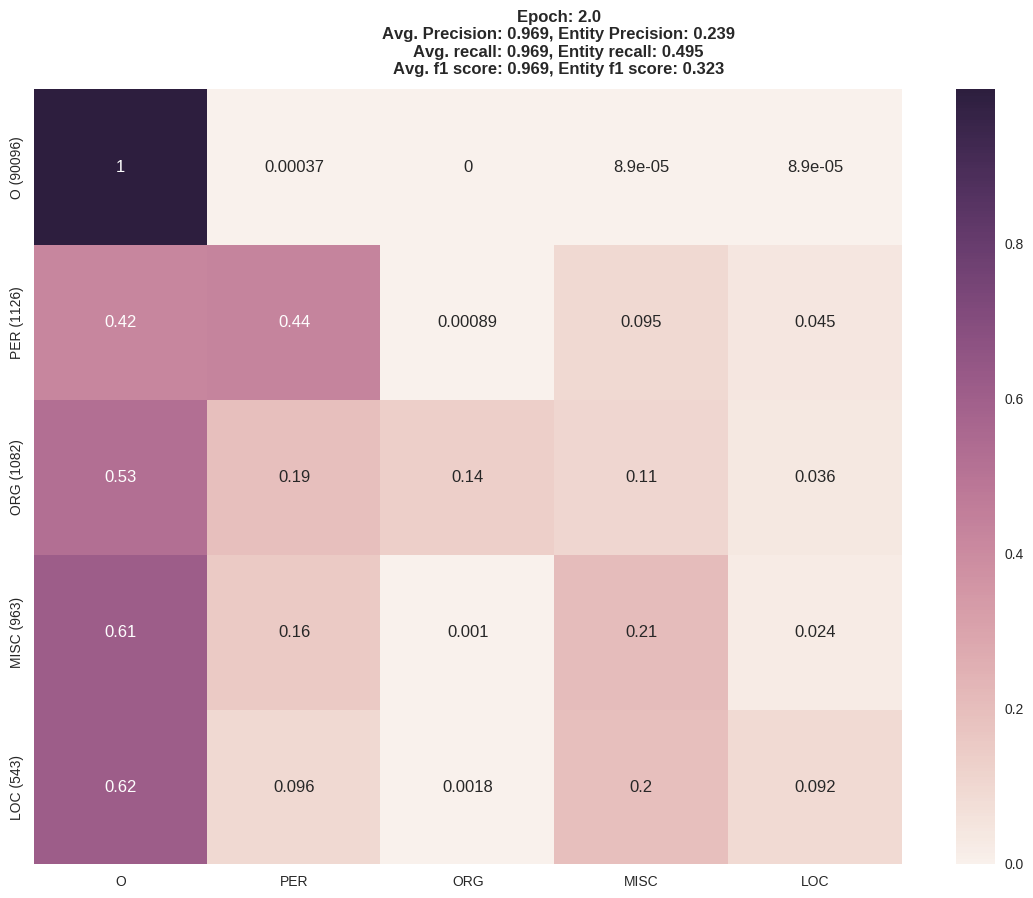

In [ ]:
"""
Define Model Parameters
"""

NUM_HIDDEN = 300
NUM_LAYERS = 3
DROPOUT = 0.5
LEARNING_RATE = 0.01

"""
Define Training Parameters
"""
BATCH_SIZE = 256
BATCH_AMOUNT = (len(train_input) + BATCH_SIZE - 1) / BATCH_SIZE
NUM_EPOCH = 50

print("Batches pr. Epoch: {}\n".format(BATCH_AMOUNT))

sess = tf.Session()
with tf.Graph().as_default():
    print("Defining variables")
    data = tf.placeholder(tf.float32,[None, MAX_SENTENCE_LENGTH, EMBEDDING_LENGTH])
    target = tf.placeholder(tf.float32, [None, MAX_SENTENCE_LENGTH, NUM_TARGETS])
    dropout = tf.placeholder(tf.float32)
    
    model = Model(data, target, dropout, NUM_HIDDEN, NUM_LAYERS, LEARNING_RATE)
    maximum = 0
    early_stop = 0
    
    with tf.Session() as sess:
        try:
            print("Initializing variables")
            sess.run(tf.initialize_all_variables())
            saver = tf.train.Saver()

            print("starting training")
            for epoch in range(NUM_EPOCH):
                ptr=0
                for batch_number in range(BATCH_AMOUNT):
                    feed_input = {
                            data: train_input[ptr:ptr+BATCH_SIZE], 
                            target: train_target[ptr:ptr+BATCH_SIZE], 
                            dropout: DROPOUT
                    }

                    ptr += BATCH_SIZE
                    sess.run(model.optimize, feed_input)
                #if epoch % 10 == 0:
                    #save_path = saver.save(sess, "model/model.ckpt")
                    #print("Model saved in file: %s" % save_path)
                pred = sess.run(model.prediction, {data: dev_input, target: dev_target, dropout: 1})
                pred, length = sess.run(model.getpredf1, {data: dev_input, target: dev_target, dropout: 1})
                #print "Epoch: {} out of {}".format(epoch, NUM_EPOCH)

                m = f1(pred, dev_target, epoch)
                    
                if m > maximum:
                    maximum = m
                    #save_path = saver.save(sess, "model/model_max.ckpt")
                    #print("Max Model saved in file: %s" % save_path)

                    pred = sess.run(model.prediction, {data: validation_input, target: validation_target, dropout: 1})

                    pred, length = sess.run(model.getpredf1, {data: validation_input, target: validation_target, dropout: 1})
                    #print "TestB score,"
                    f1(pred, validation_target, epoch, file_name="max_confusion_matrix.png")
                    #print"\n\n"
                else:
                    early_stop += 1
                    if early_stop == 10:
                        break
                
        except KeyboardInterrupt:
            print('Closing down')
            sess.close()